# Downloading Dataset

In [1]:
# update gdown
!pip install --upgrade --no-cache-dir gdown

In [2]:
%%bash
# download zip dataset file 
gdown "https://drive.google.com/u/0/uc?id=10J97YhL_0YB298fqekLm0t9rU9jRWEoD" -O dataset.zip

# upzip dataset
unzip dataset.zip

# remove original zip file 
rm dataset.zip

Archive:  dataset.zip
   creating: train-data/
   creating: train-data/okyjD0/
  inflating: train-data/okyjD0/okyjD_2K_Albedo.jpg  
  inflating: train-data/okyjD0/semanticTags.json  
   creating: train-data/okyjF0/
  inflating: train-data/okyjF0/okyjF_2K_Albedo.jpg  
  inflating: train-data/okyjF0/semanticTags.json  
   creating: train-data/okyjJ0/
  inflating: train-data/okyjJ0/okyjJ_2K_Albedo.jpg  
  inflating: train-data/okyjJ0/semanticTags.json  
   creating: train-data/okyjl0/
  inflating: train-data/okyjl0/okyjl_2K_Albedo.jpg  
  inflating: train-data/okyjl0/semanticTags.json  
   creating: train-data/okyjp0/
  inflating: train-data/okyjp0/okyjp_2K_Albedo.jpg  
  inflating: train-data/okyjp0/semanticTags.json  
   creating: train-data/okyjpmp0/
  inflating: train-data/okyjpmp0/okyjpmp_2K_Albedo.jpg  
  inflating: train-data/okyjpmp0/semanticTags.json  
   creating: train-data/okyjqtp0/
  inflating: train-data/okyjqtp0/okyjqtp_2K_Albedo.jpg  
  inflating: train-data/okyjqtp0/seman

Downloading...
From: https://drive.google.com/u/0/uc?id=10J97YhL_0YB298fqekLm0t9rU9jRWEoD
To: /content/dataset.zip
100%|██████████| 1.16G/1.16G [00:10<00:00, 109MB/s]


# Visualizing Dataset

In [1]:
# path to main dataset directory 
# remaining notebook will use this value
DATASET_PATH = "train-data"

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import os
import glob
import json
import random

In [4]:
from pprint import pprint

In [5]:
# reading a sample json 
with open("train-data/okyjD0/semanticTags.json", 'r') as f:
    data = json.load(f)
    pprint(data)

{'color': ['brown'],
 'contains': ['grass', 'leaves', 'dried grass', 'dried leaves'],
 'environment': ['grassland biome', 'forest biome', 'rural'],
 'name': 'Dried Leaves and Grass',
 'state': ['old', 'damaged'],
 'subject_matter': 'nature',
 'theme': ['dry',
           ' dead',
           ' fallen',
           ' ground',
           ' forest',
           ' drylands',
           'ground']}


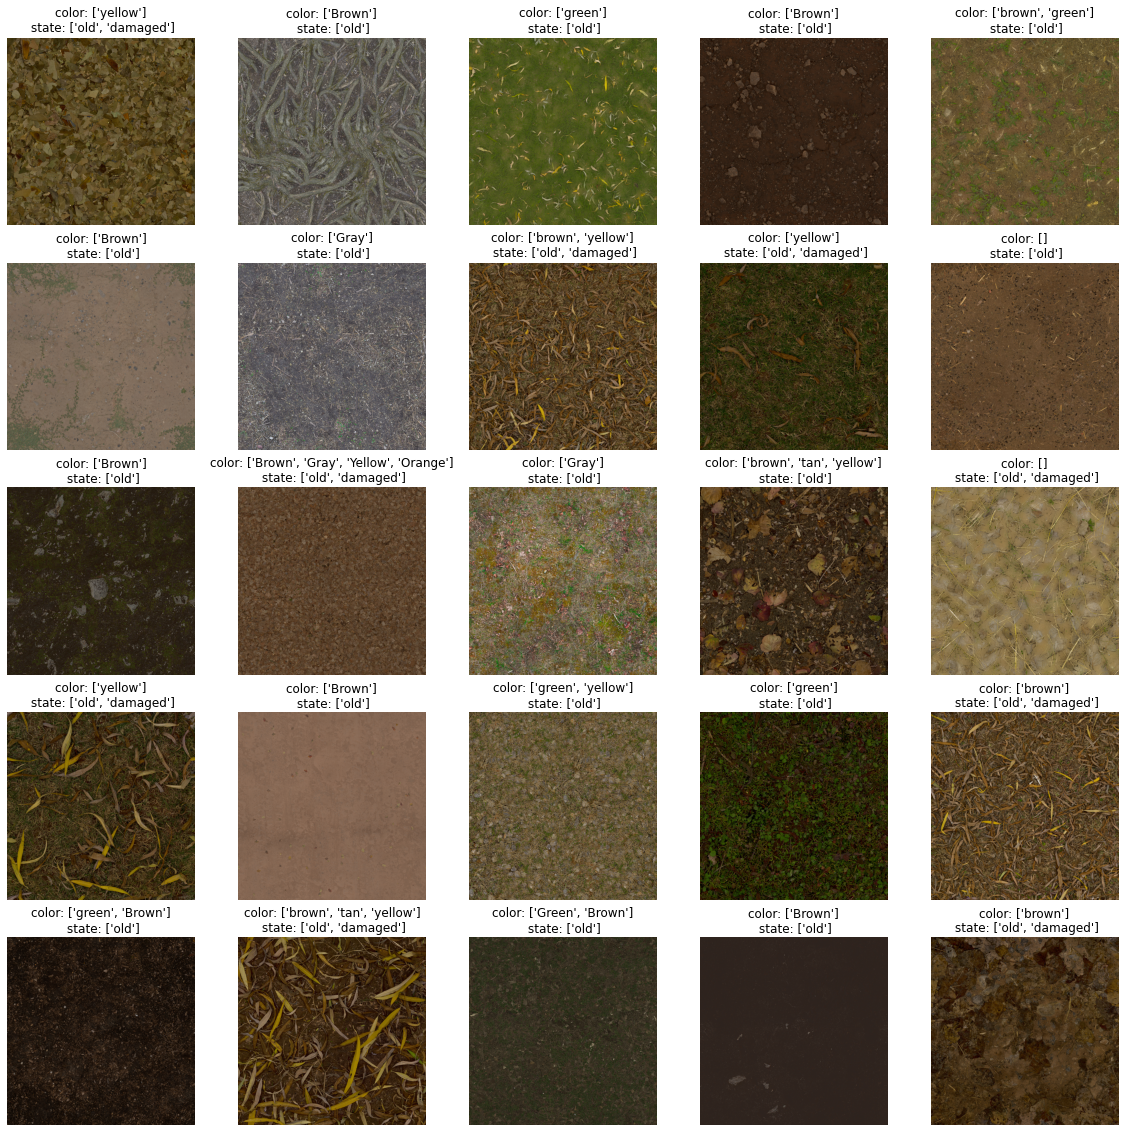

In [6]:
nrows = 5
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# list of data samples 
data_path_list = glob.glob(os.path.join(DATASET_PATH, "*"))

# sampling items randomly 
path_list = random.sample(data_path_list, nrows*ncols)

for i, dir_path in enumerate(path_list):
    # defining subplot
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # hide axis

    # plotting image 
    img_path = glob.glob(os.path.join(dir_path, "*.jpg"))[0]
    img = Image.open(img_path)
    plt.imshow(img)

    # reading label 
    label_path = os.path.join(dir_path, "semanticTags.json")
    with open(label_path, 'r') as f:
        label = json.load(f)
        plt.title(f"color: {label.get('color', [])}\n state: {label.get('state', [])}")

plt.show()

# Data Preprocessing

In [7]:
# creating empty dataframe 
df = pd.DataFrame(columns = ['id', 'img_path', 'color', 'state'])

data_path_list = glob.glob(os.path.join(DATASET_PATH, "*"))

for i, dir_path in enumerate(data_path_list):
    # forming required paths 
    img_path = glob.glob(os.path.join(dir_path, "*.jpg"))[0]
    label_path = os.path.join(dir_path, "semanticTags.json")
    
    with open(label_path, 'r') as f:
        label = json.load(f)

        color = label.get("color", [])
        state = label.get("state", [])

        # appending row to dataframe 
        df.loc[len(df.index)] = [i, img_path, color, state]

In [8]:
df.head()

,id,img_path,color,state
0,0,train-data/uc0kedqkw/uc0kedqkw_2K_Albedo.jpg,[],[old]
1,1,train-data/umsldenlw/umsldenlw_2K_Albedo.jpg,[Brown],"[old, damaged]"
2,2,train-data/pftlI0/pftlI_2K_Albedo.jpg,"[brown, green]",[old]
3,3,train-data/tijmbfkxa/tijmbfkxa_2K_Albedo.jpg,[black],[old]
4,4,train-data/vmciaekg/vmciaekg_2K_Albedo.jpg,"[Brown, Green]",[old]


In [9]:
# lowercasing all values 
df['color'] = df['color'].apply(lambda x: [v.lower() for v in x])
df['state'] = df['state'].apply(lambda x: [v.lower() for v in x])

In [10]:
# converting columns to one-hot encoding 
# ref: https://python.tutorialink.com/python-how-to-one-hot-encode-a-feature-with-multiple-values/
def one_hot_column(dataframe, col_name): 
    df_out = dataframe.explode(col_name)
    df_out = df_out.pivot_table(index="id", columns=col_name, aggfunc="size", fill_value=0.)
    df_out = df_out.add_prefix(f"{col_name}_")

    return df_out

In [11]:
df_color =  one_hot_column(df, "color")
df_state =  one_hot_column(df, "state")

In [12]:
# combining df_color, df_state and other columns
df = pd.concat([
        df.set_index("id").img_path,
        df_state,
        df_color,
    ], axis=1)

In [13]:
df.head()

,img_path,state_damaged,state_new,state_old,color_black,color_brown,color_gold,color_gray,color_green,color_ivory,color_ochre,color_orange,color_red,color_silver,color_tan,color_taupe,color_umber,color_white,color_yellow
id,,,,,,,,,,,,,,,,,,,
0,train-data/uc0kedqkw/uc0kedqkw_2K_Albedo.jpg,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train-data/umsldenlw/umsldenlw_2K_Albedo.jpg,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train-data/pftlI0/pftlI_2K_Albedo.jpg,0,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train-data/tijmbfkxa/tijmbfkxa_2K_Albedo.jpg,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train-data/vmciaekg/vmciaekg_2K_Albedo.jpg,0,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# filling all NaNs with 0.0
df = df.fillna(0.)

In [15]:
# converting all numeric columns to float 
df.loc[:, df.columns != 'img_path'] = df.loc[:, df.columns != 'img_path'].astype(float)

In [16]:
df.head()

,img_path,state_damaged,state_new,state_old,color_black,color_brown,color_gold,color_gray,color_green,color_ivory,color_ochre,color_orange,color_red,color_silver,color_tan,color_taupe,color_umber,color_white,color_yellow
id,,,,,,,,,,,,,,,,,,,
0,train-data/uc0kedqkw/uc0kedqkw_2K_Albedo.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,train-data/umsldenlw/umsldenlw_2K_Albedo.jpg,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train-data/pftlI0/pftlI_2K_Albedo.jpg,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train-data/tijmbfkxa/tijmbfkxa_2K_Albedo.jpg,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train-data/vmciaekg/vmciaekg_2K_Albedo.jpg,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# saving as csv 
df.to_csv("labels.csv")

# Dataset Stats

In [17]:
print(f"Dataset Size: {len(df)}")

# -1 for img_path column
print(f"Label Size: {len(df.columns) -1}")

Dataset Size: 300
Label Size: 18


In [20]:
# getting state columns
state_cols = [col for col in df.columns if "state_" in col]
print(f"Total States: {len(state_cols)}")
print([s.replace("state_", "") for s in state_cols])

Total States: 3
['damaged', 'new', 'old']


In [21]:
# getting color columns
color_cols = [col for col in df.columns if "color_" in col]
print(f"Total Colors: {len(color_cols)}")
print([s.replace("color_", "") for s in color_cols])

Total Colors: 15
['black', 'brown', 'gold', 'gray', 'green', 'ivory', 'ochre', 'orange', 'red', 'silver', 'tan', 'taupe', 'umber', 'white', 'yellow']
